In [1]:
# install for AWS
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision
!pip install s3fs
!pip install boto3
!pip install tqdm
# !pip install fiftyone

DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standa

In [2]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from io import BytesIO
from torch import nn, optim
from tqdm import tqdm

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# import fiftyone as fo
# import fiftyone.brain as fob
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F

# Define Hyperparams

In [3]:
batch_size = 32
learning_rate = 0.001
fine_tune_learning_rate = learning_rate / 10
num_classes = 52
num_epochs = 2
fine_tune_epochs = 2
disparity_weight = 0.1
alpha = 0.5
temperature = 5.0

# Load, Transform, and Split Data

In [4]:
# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

In [5]:
# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [6]:
# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}annotations.csv'
df = pd.read_csv(annotations_s3_path)

In [7]:
# Extracting unique class labels from the 'class1' column
classes = df['class1'].unique()

# Creating a mapping from index to class label
idx_to_class = {i: j for i, j in enumerate(classes)}

# Creating a reverse mapping from class label to index
class_to_idx = {value: key for key, value in idx_to_class.items()}

# Creating a mapping from index to annotation column name starting from the 7th column
idx_to_annot = {i: j for i, j in enumerate(df.columns[6:])}


In [8]:
# # check count of jpg files
# def count_jpg_files(bucket_name, prefix=''):
#     """
#     Count the number of .jpg files in an S3 bucket under a given prefix.
    
#     Parameters:
#     - bucket_name (str): Name of the S3 bucket.
#     - prefix (str): Prefix path to filter results. Default is empty.
    
#     Returns:
#     - count (int): Count of .jpg files.
#     """
#     count = 0
#     paginator = s3_client.get_paginator('list_objects_v2')
    
#     for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
#         for obj in page.get('Contents', []):
#             if obj['Key'].endswith('.jpg'):
#                 count += 1

#     return count

# # Count .jpg files in the 'w210facetdata' bucket under the 'images/' prefix
# jpg_count = count_jpg_files(bucket_name, images_prefix)
# print(f"Number of .jpg files in the '{bucket_name}/{images_prefix}' path: {jpg_count}")


In [9]:
# df.iloc[0][6:]

In [10]:
# idx_to_class

In [11]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [13]:
# toggle on/off subsetting
# Define the number of samples you want in your subset
subset_size = 200  # Adjust the size as needed

# Create a smaller subset of your dataset
train_data = train_data[:subset_size]
test_data = test_data[:subset_size]
val_data = val_data[:subset_size]

In [14]:
# Define additional metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Lists to store metric values during training
train_losses_student, val_losses_student, train_losses_teacher, val_losses_teacher = [], [], [], []
train_accuracies_student, val_accuracies_student, train_accuracies_teacher, val_accuracies_teacher = [], [], [], []


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 2]
        image_key = f'{images_prefix}{img_name}'  # Construct S3 object key
        # Load image from S3
        img_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        img_data = img_object['Body'].read()
        # Open the image directly from the byte stream using PIL
        image = Image.open(BytesIO(img_data))
        annotations = self.data.iloc[idx, 6:].values.astype(np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = 'FACET'  # Local directory if you want to save images locally
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# fig = plt.figure()

# for i, sample in enumerate(train_dataset):
#     ax = plt.subplot(1, 4, i + 1)
#     plt.imshow(np.transpose(sample[0], [1,2,0]))
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.show()
#     if i == 3:
#         break


# Model

In [18]:
# device = torch.device('mps')

# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=52):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(131072, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = torchvision.models.resnet50(pretrained=True)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, num_classes)
teacher_model = teacher_model.to(device)

student_model = LightNN(num_classes=num_classes).to(device)

# Load pre-trained weights if available
pretrained_path = 'pretrained_student.pth'
if os.path.exists(pretrained_path):
    student_model.load_state_dict(torch.load(pretrained_path))
    print("Loaded pre-trained weights for student model.")

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)


# Train


In [19]:
# Define attributes and concepts in your dataset
attributes = df.columns[6:].tolist()  # All attributes
concepts = list(idx_to_class.values())  # All concepts

# Create a dictionary to map attribute names to column indices
attr_idx = {attr: idx for idx, attr in enumerate(attributes)}

# Initialize dictionaries to store recall values for teacher and student models
teacher_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
student_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}


Epoch 1/4:  14%|██████████▋                                                                | 1/7 [00:10<01:00, 10.02s/it]

KD Loss: 4.3487085349624977e-05
CE Loss: 3.9503986835479736
Disparity Loss: 0.0
Total Loss: 1.975221037864685
teacher_recall: nan, student_recall: nan
Labels: [ 1 36 44 44 21 26 40 19 14  4 28 31  4 15  9  4 30 11 23  8 26 18  1  9
 26  9 16 40 31  8  4  7]
Student Predictions: [ 7 51  7 28  7  7 32  7  7 32 32 32 32  7 32 32 32 32 32 32 28 32 32  7
  7  7  7  7 33 32 32  7]
Teacher Predictions: [ 4 30 40 30  3 18 40 40 24  3  3 40 40  3 30 40 30 40 19 19 19 30 42 40
 45 19 40 40  4 19  3 19]
Student Outputs: tensor([[-0.0326,  0.0248, -0.0898,  ...,  0.0439, -0.0823,  0.0135],
        [-0.0306, -0.0292, -0.1220,  ...,  0.0295,  0.0164,  0.1479],
        [-0.0907, -0.0323, -0.1177,  ...,  0.0109, -0.0430,  0.0646],
        ...,
        [-0.0607, -0.0470, -0.0983,  ...,  0.0253,  0.0399,  0.0263],
        [-0.1031, -0.0018, -0.0325,  ..., -0.0078, -0.0321,  0.0532],
        [-0.0301,  0.0237, -0.0725,  ...,  0.0043,  0.0244,  0.0689]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 1/4:  29%|█████████████████████▍                                                     | 2/7 [00:20<00:50, 10.00s/it]

KD Loss: 0.007983816787600517
CE Loss: 11.921226501464844
Disparity Loss: 0.0
Total Loss: 5.964605331420898
teacher_recall: nan, student_recall: nan
Labels: [23 22 33 17 15 42  3  3 15 35 30  6  4 28 41 37 19 20 18 36  4  8 41  1
 14 14 28 22  3 26 39  9]
Student Predictions: [26  4  4  4  4  4  4  4  4 26  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4 26  4 26  4  4  4  4]
Teacher Predictions: [ 7 37 13  7 33  7 13 25 25  7  7 37 32 31 13 29 25 13 51 32 32  7 27 34
 33 32  7 43 43 51 21  7]
Student Outputs: tensor([[-1.0900,  1.2389, -4.8672,  ...,  1.8109, -2.3125, -1.9818],
        [-2.1214,  1.5662, -6.5452,  ...,  0.3967, -2.9783, -1.9448],
        [-2.1380,  3.2923, -7.5464,  ...,  0.3330, -2.7172, -1.9125],
        ...,
        [-2.0228,  4.2966, -7.4903,  ...,  2.6448, -1.4681, -2.0014],
        [-2.7472,  1.4304, -5.7221,  ...,  1.9702, -3.4448, -0.9524],
        [-2.6254,  3.3246, -5.4795,  ...,  0.2634, -2.8313, -0.7556]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: ten

Epoch 1/4:  43%|████████████████████████████████▏                                          | 3/7 [00:29<00:39,  9.78s/it]

KD Loss: 0.005602926481515169
CE Loss: 8.034217834472656
Disparity Loss: 0.0
Total Loss: 4.0199103355407715
teacher_recall: nan, student_recall: nan
Labels: [18 24 13 36 16 23 44  4  4  1 32 19 19  3  1 36 23 19  5 22 44  9 15  1
  9 44 35  5 44  6  4 11]
Student Predictions: [18 26  9 15  9  9  9 15  9 15  9 26 15 18  9  9  9  9  9 26 26  9 15  9
  9 26  9  9 26 15  9  9]
Teacher Predictions: [32 32 32 13 25 13 25 32 36 32  9  7  7 25 13 32  7 32  7  7 37  7 32 32
 21 13 13 32 25 32  7 32]
Student Outputs: tensor([[ -2.0150,   3.1280,  -8.0174,  ...,  -0.7407,  -8.3527,  -3.9075],
        [ -1.4240,   5.7341,  -5.7933,  ...,   1.7280,  -7.8586,  -2.5140],
        [ -0.8873,   4.6518,  -7.8830,  ...,   0.0572,  -9.4736,  -0.9121],
        ...,
        [ -1.7125,   2.3794,  -5.6277,  ...,  -0.1992,  -6.2461,  -2.1451],
        [ -2.1471,   6.1234,  -7.6111,  ...,   0.0908,  -7.7143,  -1.9522],
        [  0.2398,   7.2388,  -9.6848,  ...,   0.4651, -12.6480,  -2.3737]],
       grad_fn=<A

Epoch 1/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:39<00:29,  9.93s/it]

KD Loss: 0.002543979324400425
CE Loss: 7.878422260284424
Disparity Loss: 0.0
Total Loss: 3.9404830932617188
teacher_recall: nan, student_recall: nan
Labels: [ 3 40  5 43 10 20  4  4  1  5  4 28 20 22  4 22 21 17  8 22  1 48 11 36
 17 21 43 35 49 16 33  4]
Student Predictions: [ 1  1 18 18 18 18  9  1  1 18 18 18 13 18  1  1  1 13 18  1 18  1  9  9
  1  9 28 13 18 18  9 13]
Teacher Predictions: [ 9  9 13  9  9 21  9 21  9 21  9 13 13 13 13  9 21 13 36 21 13 13 13 36
  9  9 13 37 36 13 13  9]
Student Outputs: tensor([[-3.0200,  7.8474, -4.7666,  ...,  0.8811, -8.7939, -0.1350],
        [-2.2410,  6.7118, -5.9738,  ...,  0.2244, -9.9910,  0.7023],
        [-2.3750,  3.3211, -3.4676,  ...,  0.8606, -6.6682, -0.2259],
        ...,
        [-1.3050,  2.1427, -4.5913,  ...,  0.7882, -4.7017, -1.4351],
        [-1.9901,  6.2081, -5.9627,  ...,  0.5525, -8.4329,  0.1051],
        [-2.4512,  4.0815, -3.8634,  ...,  0.4030, -8.5932, -3.0661]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: ten

Epoch 1/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [00:50<00:20, 10.38s/it]

KD Loss: 0.0018671057187020779
CE Loss: 6.618957042694092
Disparity Loss: 0.0
Total Loss: 3.3104121685028076
teacher_recall: nan, student_recall: nan
Labels: [11  3 19  1  2  4  6 31 15  4 15  1  1 26 30 16 11 21  4  3 33 23  3  4
  4 11  4 50  1 19 27 23]
Student Predictions: [44  5  5  1  5 14  1  1 14 44 13  5 13 14 28  6  1 44  1 13 28 13 28 28
 28 44  1 28  5 13 28  1]
Teacher Predictions: [13 13 13 13 13  9 13  9 36  9  9  9  9 36  9  9 13 13 13  9  9 13 13 13
 13  9  9 13 13 36 36 13]
Student Outputs: tensor([[ -2.8294,   3.1966,  -4.2422,  ...,  -0.1274, -10.0641,  -1.5081],
        [ -2.9648,   2.4697,  -1.3065,  ...,  -0.4727,  -6.2239,  -0.2029],
        [ -2.8188,   3.8335,  -2.9347,  ...,   0.0918,  -8.2818,  -1.0030],
        ...,
        [ -2.2278,   3.5031,  -3.1031,  ...,  -1.0373,  -7.6041,  -0.8214],
        [ -3.1943,   3.1366,  -2.2967,  ...,  -0.1578,  -7.8742,  -1.2925],
        [ -1.1108,   3.5248,  -1.6680,  ...,   0.8623,  -5.1267,  -0.9539]],
       grad_fn=<

Epoch 1/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [01:00<00:10, 10.10s/it]

KD Loss: 0.0012937199790030718
CE Loss: 5.321377277374268
Disparity Loss: 0.0
Total Loss: 2.6613354682922363
teacher_recall: nan, student_recall: nan
Labels: [40 44 11  4 10 21 37 46 45  4  3 50  4 28 41  0 20  5 40  4 11  6  1 35
 36  5  1 10 37  8  4  5]
Student Predictions: [13 44 44  5 44  1  1 44 44 13  1 14 44  1  5 44 44  5 44  5 14 44  6 40
  5 28  1 44  5 44 44  1]
Teacher Predictions: [13 13 13 13 13 13 13 13 13  9 13  9 13 13 13 13 13 13 13 13 13 13  9 13
 13 13 13 13 13 13 13 13]
Student Outputs: tensor([[-2.7310,  2.1226, -1.2087,  ..., -0.3207, -5.0916, -1.9103],
        [-1.3674,  0.3260, -0.7465,  ...,  0.3005, -3.3653, -0.9688],
        [-1.2448,  1.2103, -0.3374,  ..., -0.2579, -3.3124, -0.5245],
        ...,
        [-3.8015,  2.1792, -1.1423,  ..., -1.3023, -7.0274, -1.8233],
        [-2.3542,  1.5048, -0.8161,  ..., -1.4877, -4.9162, -1.1886],
        [-4.3841,  4.5641, -1.0138,  ..., -1.0039, -6.4785, -1.8602]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 1/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:02<00:00,  8.97s/it]


KD Loss: 0.0009339551907032728
CE Loss: 5.283181190490723
Disparity Loss: 0.0
Total Loss: 2.6420576572418213
teacher_recall: nan, student_recall: nan
Labels: [ 4  4 35 14  8 22  7  6]
Student Predictions: [44 17  1 20 20 20 21 40]
Teacher Predictions: [13 13 13 13 13 13 13 13]
Student Outputs: tensor([[-1.4271e+00,  8.1150e-01, -5.1607e-01,  9.2904e-01, -2.9421e+00,
          1.1500e+00,  7.9999e-01, -2.6606e-01,  7.8730e-01, -9.6855e-01,
          3.9858e-01,  1.7815e-01, -1.0567e+00,  6.9155e-01,  7.7618e-01,
         -3.8468e-01,  3.7262e-01,  6.6477e-01,  3.8797e-01, -4.0237e-01,
          8.8988e-01,  1.1957e+00,  6.5596e-01,  1.1849e+00, -1.0498e+00,
         -7.5031e-01, -5.0453e-03, -1.7771e-01,  6.0826e-01, -1.7725e+00,
          5.8512e-01,  2.0368e-01,  4.1757e-01,  6.3853e-01, -1.4756e+00,
          4.4375e-01,  8.4237e-01, -3.6081e-01, -1.4404e+00, -6.5059e-01,
          3.9803e-01,  1.1209e+00, -1.8660e-01, -3.8452e-01,  1.2244e+00,
         -1.2407e+00, -7.1139e-01, -7.8

Epoch 2/4:  14%|██████████▋                                                                | 1/7 [00:09<00:56,  9.37s/it]

KD Loss: 0.0006426037871278822
CE Loss: 3.865346908569336
Disparity Loss: 0.0
Total Loss: 1.9329947233200073
teacher_recall: nan, student_recall: nan
Labels: [23 19 44  5 11 44  5  5  4 15  5  7  1  1  4 22  6  4 28  4 26 41 30 33
 40 10  1 37 11  3  4  4]
Student Predictions: [20 20 20  5  5 20  5 14 20 23 20 21 20 20 41 20 20 20 21 20 20 20 20  5
 20 20 33 41 20 11 20 20]
Teacher Predictions: [13  1 13 13 13 13 13 13 13 13 13 13 13 13 13 13  1 13 13 13 13 13  1 13
  1 13 13 13 13 13 13 13]
Student Outputs: tensor([[-0.7522,  0.9050, -0.4840,  ...,  0.3352, -1.5704, -0.6893],
        [-0.8447,  0.8310, -0.1257,  ..., -0.2845, -1.5888, -0.9898],
        [-0.5270,  0.2556, -0.0970,  ..., -0.2822, -1.1411, -0.3481],
        ...,
        [-1.0067,  0.9168, -0.2674,  ..., -0.2916, -1.1780, -0.4104],
        [-1.7982,  1.6506,  0.3353,  ..., -0.3530, -1.5965, -0.2448],
        [-1.1249,  1.2000,  0.1246,  ..., -0.2907, -2.0747, -1.1199]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 2/4:  29%|█████████████████████▍                                                     | 2/7 [00:18<00:47,  9.45s/it]

KD Loss: 0.00039640950853936374
CE Loss: 3.4485604763031006
Disparity Loss: 0.0
Total Loss: 1.7244784832000732
teacher_recall: nan, student_recall: nan
Labels: [21 11 35  9 28 14 15  5 50  8 43 19 30 31 43 20  4  8 44 22 36 14 35 11
 10  1 35 41 22 19  4 23]
Student Predictions: [20 14 41 20 20 20 14 17 41 20 21 20 20 20 20 21  5 20 20 41 21 14 41  5
 20 20 41 41 44 20  3 14]
Teacher Predictions: [13  1 13 13 13 13 13 13  1 13 13 13  1  1 13  1 13 13 13 13 13 13 13 13
 13  1 13  1 13 13 13  1]
Student Outputs: tensor([[-0.6454,  0.4211,  0.0244,  ..., -0.0204, -1.0937, -0.2924],
        [-0.5144,  1.1290,  0.4008,  ..., -0.0989, -1.7025, -0.8829],
        [-0.3907,  0.2000, -0.1583,  ..., -0.3341, -0.6289, -0.7034],
        ...,
        [-0.3415,  0.9802,  0.6170,  ..., -0.5062, -1.5204, -0.7263],
        [-0.1096,  0.0774,  0.1682,  ..., -0.0485, -0.4338, -0.4002],
        [-0.5765,  0.1624, -0.0051,  ..., -0.5624, -0.9290, -0.7597]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 2/4:  43%|████████████████████████████████▏                                          | 3/7 [00:27<00:36,  9.12s/it]

KD Loss: 0.00035180331906303763
CE Loss: 3.870680332183838
Disparity Loss: 0.0
Total Loss: 1.935516119003296
teacher_recall: nan, student_recall: nan
Labels: [ 4 35 20 22 22 36 20  1  5  4 23 26  4 16 49  3 37  9 44 35 17 31 33 10
  4  9 33 45  4 21  4 23]
Student Predictions: [20 20 20 20  5 20 21 31 20 20 20 35 20  3 20  3 17 20 20 20 20 20 44  3
 20 21 20 20 20 21  5 20]
Teacher Predictions: [13 13 13 13  1 13  1 13 44  1  1 13  1 13 13 13  1 13 13  1 44  1 13 13
 13  1  1 13  1 13 13 13]
Student Outputs: tensor([[-0.2111,  0.1629, -0.0559,  ..., -0.3925, -0.4931, -0.4999],
        [-0.8067,  0.6357,  0.0769,  ..., -0.4879, -1.2480, -0.8935],
        [-0.9841,  0.0128,  0.0404,  ..., -1.2332, -1.5122, -1.2518],
        ...,
        [-0.4186,  0.3606, -0.0119,  ..., -0.2313, -0.5649, -0.4226],
        [-0.5442,  0.1434, -0.2354,  ..., -0.0701, -0.3235, -0.4979],
        [-0.3059,  0.3368,  0.1030,  ...,  0.0150, -0.3963, -0.3853]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 2/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:36<00:26,  9.00s/it]

KD Loss: 0.0002913976786658168
CE Loss: 3.996317148208618
Disparity Loss: 0.0
Total Loss: 1.9983042478561401
teacher_recall: nan, student_recall: nan
Labels: [ 8 23  4  2 26  6 15  9  3 44  9  1  4 28 18 18 44 26 16  1  9  4  4  1
 19 19  5  4 26 48 14  8]
Student Predictions: [41  3 20 20  3 20 44 20  5 14 20 20 20 21 44 41 41 11  5 20 20 20 20  1
 19 10 41 41  3 20 14 41]
Teacher Predictions: [44 44  1  1 44  1 44  1 44 44 44  1  1  1 44  1 44  1  1 44 44 44 44 44
  1 44 44 44 44 44 44  1]
Student Outputs: tensor([[-0.4178, -0.0913, -0.1011,  ..., -0.2314, -0.1725, -0.5205],
        [-0.0988, -0.0770, -0.0216,  ...,  0.0312,  0.0153, -0.0667],
        [-0.3294,  0.2994,  0.0598,  ..., -0.7873, -0.8218, -0.5258],
        ...,
        [-0.7161,  0.5874,  0.2534,  ..., -0.6202, -0.9236, -0.8872],
        [-0.9143, -0.5569, -0.4067,  ..., -0.2561, -1.0862, -1.8254],
        [-0.1591, -0.0298, -0.1907,  ..., -0.1183, -0.1279, -0.4537]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 2/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [00:45<00:18,  9.17s/it]

KD Loss: 0.00028379878494888544
CE Loss: 3.5573766231536865
Disparity Loss: 0.0
Total Loss: 1.7788301706314087
teacher_recall: nan, student_recall: nan
Labels: [18  3 19 32  4 36 19 24  1 44 16  8  3 13 11 30 36 11 27 31  6 40  1 21
 36  1 40 21  4  1  3 20]
Student Predictions: [20  3 10 20 20 22 20 23  5 14 20 20 41 20 10 22  5 20 10 20 20 11 14 20
 44 20 40 22 20 11  5 20]
Teacher Predictions: [44 44 44 44  1 44 44  1 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44  1 44 44  1 44 44]
Student Outputs: tensor([[-0.4937, -0.2618, -0.1414,  ..., -0.3666, -0.2551, -0.6306],
        [-0.5812, -0.1222, -0.2164,  ..., -0.4143,  0.0056, -0.6687],
        [ 0.2327,  0.4237,  0.2095,  ..., -0.3374, -0.3103, -0.5879],
        ...,
        [-0.7416,  0.5452, -0.0064,  ..., -0.3245, -0.2460, -0.6661],
        [-0.3487,  0.1801,  0.0014,  ...,  0.0322, -0.1775, -0.1732],
        [-0.5566, -0.5373, -0.1768,  ..., -0.6520, -0.1602, -0.4655]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 2/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [00:55<00:09,  9.17s/it]

KD Loss: 0.00019230811449233443
CE Loss: 3.683797597885132
Disparity Loss: 0.0
Total Loss: 1.8419950008392334
teacher_recall: nan, student_recall: nan
Labels: [22 15 39  0 11 41  3 40 15 22 42 46 15 17 17  4 28  4  1 23 14  4 16 50
  8 28  4  1  6  4 36 21]
Student Predictions: [22  3  5 20 20 41  5 20 20 22 10  5 10 20  5 28 11  5  5 23 21 20  4 20
 14 23 41 19  5 20 36 20]
Teacher Predictions: [ 1 44 44 44 44  1 44 44 44 44 44 44 44 44  1 44 44 44 44  1  1  1 44 44
  1 44  1 44 44  1 44 44]
Student Outputs: tensor([[-0.3077,  0.0537, -0.1534,  ..., -0.1838, -0.5880, -0.8030],
        [-0.0978, -0.0528, -0.0445,  ...,  0.0392,  0.0349, -0.0929],
        [-0.2733,  0.1530, -0.1153,  ...,  0.0033, -0.1223, -0.4297],
        ...,
        [-0.1856,  0.0197, -0.1304,  ..., -0.1861, -0.0837, -0.2892],
        [-0.2218, -0.0998, -0.1693,  ..., -0.1241, -0.1424, -0.5719],
        [-0.3244,  0.2170, -0.0946,  ..., -0.0285,  0.0037, -0.2901]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 2/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.18s/it]


KD Loss: 0.00018084250041283667
CE Loss: 3.572646141052246
Disparity Loss: 0.0
Total Loss: 1.786413550376892
teacher_recall: nan, student_recall: nan
Labels: [ 6 11  3  4 37  3 40  7]
Student Predictions: [35 11 22  5  5 20 40  5]
Teacher Predictions: [44  1  1 44 44  1 44 44]
Student Outputs: tensor([[-3.8741e-02, -4.3496e-02, -1.6162e-01,  1.9073e-01,  1.5418e-01,
          3.8476e-01,  2.1142e-01,  1.1351e-01,  4.3351e-01, -6.3921e-01,
          2.6526e-01, -1.4952e-02, -5.4020e-01, -3.1917e-01,  3.7909e-01,
         -4.5186e-01,  2.8808e-01, -4.4493e-02, -2.0277e-01,  1.5135e-01,
          2.4478e-01, -6.7190e-02,  3.2254e-01,  5.0473e-02, -5.8783e-01,
         -5.3526e-01, -4.7143e-01, -2.1895e-01,  2.0544e-01, -1.1281e+00,
          2.3409e-01, -1.4872e-01, -2.7504e-02, -1.7628e-01, -7.8006e-01,
          5.6851e-01,  2.5025e-01,  3.1900e-02, -6.9190e-01, -2.6433e-01,
         -1.9915e-01,  4.2453e-01, -1.9628e-01,  6.1998e-03,  2.8234e-01,
         -3.0602e-01,  2.1655e-02, -4.8

Epoch 3/4:   0%|                                                                                   | 0/7 [00:00<?, ?it/s]

Starting fine-tuning with learning rate: 0.0001


Epoch 3/4:  14%|██████████▋                                                                | 1/7 [00:09<00:54,  9.07s/it]

KD Loss: 0.00023770138795953244
CE Loss: 3.536665201187134
Disparity Loss: 0.0
Total Loss: 1.768451452255249
teacher_recall: nan, student_recall: nan
Labels: [40 42 44 44 11 14 15 35 11 21 28  3 33 19 26 17 37 24  3 23 37 15  1  1
 16 35 40  1  1 20 20  5]
Student Predictions: [40 41 10 44 11 14 20 35 11 41  5 22 44 19 14  5 37 23 22 23 19  5  5  1
  3 14 22  5 11 20 22  5]
Teacher Predictions: [ 1 44  1 44 14 44 44 44 44 44  1 44 44  1 44 44 44  1 44  1  1 44 44 44
 44 44  1 44 44 44 44 44]
Student Outputs: tensor([[-0.2314, -0.0558, -0.0821,  ...,  0.1033, -0.0188, -0.3656],
        [ 0.0212, -0.1386, -0.1210,  ..., -0.3832,  0.1284, -1.0039],
        [-0.1126,  0.0468, -0.0618,  ..., -0.4452, -0.0522, -0.6602],
        ...,
        [-0.3202, -0.1522, -0.3780,  ..., -0.5792, -0.2115, -0.9665],
        [-0.3205,  0.2965, -0.4155,  ..., -0.2124, -0.0786, -0.7119],
        [-0.1575, -0.0223,  0.0233,  ...,  0.0103,  0.0018, -0.2805]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 3/4:  29%|█████████████████████▍                                                     | 2/7 [00:18<00:45,  9.02s/it]

KD Loss: 0.00019537100160960108
CE Loss: 3.5970590114593506
Disparity Loss: 0.0
Total Loss: 1.7986271381378174
teacher_recall: nan, student_recall: nan
Labels: [23 22 19 46  5 31  9 32  1  4 44 19 17  1 41 44  4  5 45  4 44  8  6  4
 17 23  6  8 22  4 26 39]
Student Predictions: [44 22 10 10 20 19  5 20  3 20 36 19 20 20 41 36 14 20 11 28 44  8  5  8
  1 36  8  8 22  5 22  5]
Teacher Predictions: [ 1  1 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44  1 44 44
 44 44 44  1  1 14 44 44]
Student Outputs: tensor([[-0.5164, -0.5965, -0.0679,  ..., -0.2780, -0.2815, -1.5506],
        [-0.2529,  0.0341, -0.3356,  ..., -0.2428, -0.3728, -0.8870],
        [-0.1870, -0.1983, -0.4280,  ..., -0.3179,  0.2129, -0.8162],
        ...,
        [-0.1493,  0.0445, -0.0953,  ..., -0.1166,  0.0440, -0.2791],
        [-0.2399,  0.1103, -0.2515,  ...,  0.0656, -0.0904, -0.6209],
        [-0.1768,  0.0889, -0.1236,  ..., -0.0217, -0.0049, -0.3694]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 3/4:  43%|████████████████████████████████▏                                          | 3/7 [00:26<00:35,  8.98s/it]

KD Loss: 0.00016970463912002742
CE Loss: 3.4861438274383545
Disparity Loss: 0.0
Total Loss: 1.7431567907333374
teacher_recall: nan, student_recall: nan
Labels: [14 18 15  4 50 40  1 41 44 35  3  6 11  1 22  9  8 28 11 36 35  4 36 23
 20 22  4 27  4 43 14  4]
Student Predictions: [35 10 11 20  4 28 22 41 44 35 10  5 11 11 22  5  8 11 22 14  8 22 36 23
 20  8 44 11  5 11 14  5]
Teacher Predictions: [44 44 44  1 44 44 44 44 44 44 44  1  1  1 44  1 14 44  1 44 44 44 44 44
  1 44 44  1 44 44 44 44]
Student Outputs: tensor([[-0.2599, -0.4600, -0.5850,  ...,  0.1648, -0.0930, -1.0469],
        [-0.1770, -0.1028, -0.2178,  ..., -0.2721,  0.1056, -0.6827],
        [-0.1562, -0.0046, -0.1073,  ...,  0.0033, -0.0209, -0.2526],
        ...,
        [-0.0325, -0.0724, -0.1039,  ..., -0.0341, -0.0077, -0.1391],
        [-0.7000,  0.0967, -0.5318,  ..., -0.5730, -0.6208, -1.0470],
        [ 0.0114,  0.1763, -0.0529,  ..., -0.0274,  0.0069, -0.2240]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 3/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:35<00:26,  8.95s/it]

KD Loss: 0.00016066478565335274
CE Loss: 3.51401948928833
Disparity Loss: 0.0
Total Loss: 1.7570900917053223
teacher_recall: nan, student_recall: nan
Labels: [35 21 19 20  3 48  1 22 14 15 43 23 19 18 11 41  4  9 36  5 50 10 16 44
  8  4  4  4 11 16  3 26]
Student Predictions: [35 22 19 10  3 11  5 22 14 14 14 23 20 11 14 41 10  5 36  5  5 10  4 22
  8 36  5 10 11 14  3 22]
Teacher Predictions: [ 1 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 14 44 44 14  1 44 44 44]
Student Outputs: tensor([[-0.0605, -0.2103, -0.0657,  ..., -0.0206, -0.0681, -0.4936],
        [-0.0390,  0.4529, -0.0770,  ..., -0.2144, -0.5945, -0.8538],
        [-0.0509, -0.1190, -0.1511,  ..., -0.4074, -0.1724, -0.4051],
        ...,
        [-0.2792,  0.0417, -0.1780,  ...,  0.1108, -0.1065, -0.2849],
        [-0.0610,  0.2242, -0.0152,  ...,  0.0921, -0.0534, -0.2980],
        [-0.2684,  0.4739, -0.5241,  ...,  0.3424, -0.2995, -1.2005]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 3/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [00:44<00:17,  8.77s/it]

KD Loss: 0.00018022008589468896
CE Loss: 3.599531888961792
Disparity Loss: 0.0
Total Loss: 1.7998560667037964
teacher_recall: nan, student_recall: nan
Labels: [11  2  1 36 30 19 28 16  9 36 33 26  6 10 19  8 37  4 18 22  3 15  7  1
  0  7 15 40  4  5  1  4]
Student Predictions: [11 22  7 11 14 41 22 16 11 11 14 22 22 10  8  8 22 11 36 22  3  3 19 41
 20  7 44 11 44  5  5 22]
Teacher Predictions: [14 44  1 44 44  1 44  1 44 44 44  1 44 44 44 44  1 14  1 44 44 44 44 44
 44  1 44 44  1 44 44  1]
Student Outputs: tensor([[-0.1964,  0.3102, -0.1562,  ..., -0.4442, -0.1098, -0.6066],
        [-0.3320,  0.4225,  0.1546,  ..., -0.2111, -0.1966, -0.7583],
        [-0.2902,  0.4274, -0.3641,  ...,  0.1886, -0.2179, -0.1885],
        ...,
        [-0.0131,  0.0898, -0.1115,  ...,  0.0091, -0.0825, -0.2380],
        [-0.0238,  0.1378, -0.0139,  ...,  0.0619, -0.0567, -0.1050],
        [ 0.0282, -0.0629, -0.2929,  ...,  0.1124,  0.1082, -0.5091]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 3/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [00:52<00:08,  8.72s/it]

KD Loss: 0.0001372809783788398
CE Loss: 3.6405067443847656
Disparity Loss: 0.0
Total Loss: 1.820322036743164
teacher_recall: nan, student_recall: nan
Labels: [ 3  4 31  4 28  1 10  4  8 30  4  3 28  4  3 36 21  5  4 30 40  6 26  4
  5 31  4  9 49 21 33 22]
Student Predictions: [14 19 11  4  5 20 10 28  8 22  4  5  5  5  3 36  5 14  4 14  5 22 22  5
  3 11  5  5 11 11  8 22]
Teacher Predictions: [44 14 44  1 44 14 44 44 44  1 44  1 44 44 44 44 44 44 44  1 44 44 44 44
 44 44  1 44 44 44 44 44]
Student Outputs: tensor([[ 0.0782,  0.1169, -0.1752,  ..., -0.2539, -0.0326, -0.1329],
        [-0.1764,  0.1059, -0.0482,  ..., -0.2909, -0.1433, -0.2836],
        [-0.4622, -0.0007, -0.1683,  ..., -0.2939, -0.0886, -0.3813],
        ...,
        [-0.2992,  0.2901, -0.0791,  ..., -0.0866, -0.0830, -0.3545],
        [ 0.0096,  0.0071, -0.0218,  ..., -0.0039,  0.0265, -0.1924],
        [-0.1114,  0.0374,  0.0221,  ..., -0.2122, -0.1277, -0.3927]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: te

Epoch 3/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.91s/it]


KD Loss: 0.00017937968368642032
CE Loss: 3.8497867584228516
Disparity Loss: 0.0
Total Loss: 1.924983024597168
teacher_recall: nan, student_recall: nan
Labels: [11  4  9  1 13 23  4 21]
Student Predictions: [36  5  5 44 22 23 10 14]
Teacher Predictions: [44  1 44 44  1 44  1 44]
Student Outputs: tensor([[ 3.3163e-02,  2.3132e-01, -1.8978e-01,  1.0208e-01,  4.9422e-02,
          5.1906e-01, -2.3266e-02,  4.3436e-01,  3.1425e-01, -2.9131e-01,
          2.1346e-01,  1.9896e-01, -5.6668e-01, -1.8809e-01,  1.4153e-02,
         -4.8286e-01, -8.1647e-02,  1.4971e-01, -1.1941e-01,  1.0997e-01,
          2.0310e-01, -1.2437e-01,  3.0666e-01,  3.5406e-01, -6.2539e-01,
         -4.5032e-01, -4.1862e-01, -1.8179e-01,  6.9980e-02, -5.9667e-01,
          1.3381e-01, -3.7543e-01,  5.5281e-02,  1.1431e-02, -6.2172e-01,
          3.2287e-01,  5.8918e-01,  2.0943e-02, -4.3536e-01, -2.4729e-01,
          1.7737e-01,  3.0620e-01, -2.4146e-01, -1.9907e-01,  9.4169e-03,
         -2.4544e-01, -4.0336e-02, -2.

Epoch 4/4:  14%|██████████▋                                                                | 1/7 [00:09<00:58,  9.77s/it]

KD Loss: 0.00016495323507115245
CE Loss: 3.505516290664673
Disparity Loss: 0.0
Total Loss: 1.7528406381607056
teacher_recall: nan, student_recall: nan
Labels: [ 3 35 31 16 21 17  4  1  7  3 11  5 31 13 35 22  5 15 33  3 28 22 44  4
  5 40 28  4 32 16 22 15]
Student Predictions: [ 5  8 11 19 14  8 22  1  7  3 11  5 19  5 14 22 20 41  5 43  5 22 44 36
  8 22 11 19 28 36 22 10]
Teacher Predictions: [44 44 44 44 44 44 44  1 14  1 44 44 44 14 44 44 44 44  1  1 44 44 44 44
 44 44 44  1 44 44  1 44]
Student Outputs: tensor([[-0.0665,  0.3877, -0.1269,  ...,  0.0257, -0.1502, -0.2311],
        [-0.1010, -0.0597, -0.2914,  ..., -0.1852, -0.1541, -0.2852],
        [-0.1998,  0.2698, -0.2280,  ..., -0.2486,  0.1175, -0.3936],
        ...,
        [-0.0224, -0.0290, -0.0997,  ...,  0.0212,  0.0778, -0.2478],
        [-0.7599, -0.2597, -0.8219,  ..., -2.1676, -2.0738, -2.7829],
        [-0.1478,  0.1911,  0.0501,  ..., -0.1451, -0.0742, -0.4158]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 4/4:  29%|█████████████████████▍                                                     | 2/7 [00:23<01:00, 12.05s/it]

KD Loss: 0.00015280515071935952
CE Loss: 3.5214457511901855
Disparity Loss: 0.0
Total Loss: 1.7607992887496948
teacher_recall: nan, student_recall: nan
Labels: [ 1  1 41 23  4 35  3 45 28 18 20  4  6  3 10 18 41  4  6 11  8 23 20 14
 44 24  6 17  9 26 19 41]
Student Predictions: [10  5 41 36  5 11 41  8  5 10 10  5  5  3 10 11 10  4  8 11  8 23 10 14
 10  3  6  5 40 22 19 41]
Teacher Predictions: [ 1 44 44 44  1 44 44 44 44 44 44 14 44 44 44  1 44 44 44 14 44 44 44 44
 44  1 44 44 44  1 44 44]
Student Outputs: tensor([[-0.3941,  0.2581, -0.2461,  ..., -0.2733,  0.0557, -0.5914],
        [ 0.0233,  0.3090, -0.0323,  ...,  0.1512, -0.0882, -0.2499],
        [-0.0197, -0.1473, -0.2897,  ..., -0.3189, -0.0450, -0.6727],
        ...,
        [-0.2524,  0.1962, -0.5299,  ..., -0.1465, -0.1570, -0.6659],
        [-0.3095,  0.1389,  0.1123,  ..., -0.0997, -0.1750, -0.1607],
        [-0.6312,  0.0223, -0.4027,  ..., -0.3969, -0.0883, -0.8575]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 4/4:  43%|████████████████████████████████▏                                          | 3/7 [00:32<00:42, 10.60s/it]

KD Loss: 0.0001534174516564235
CE Loss: 3.5068790912628174
Disparity Loss: 0.0
Total Loss: 1.7535161972045898
teacher_recall: nan, student_recall: nan
Labels: [ 4 17  7  4  1  1 49  5 14  3  4 11  4 50 22 46 40 19 26 37  1  1  2 19
 30 19 37 19 21  1 20  4]
Student Predictions: [20  5 21 44  5 11  5  5 14  3 22  8 10 36 22 36 22  8 22  5  5 22 11 19
 23 19 37 19 22 10 11 22]
Teacher Predictions: [44 44 44 44 44 44 44 44 44 44 44  1 44 44 44 44  1  1 44 44 44 44 44 44
  1 44 14 44 44 44 44 14]
Student Outputs: tensor([[-0.1702,  0.2880, -0.1213,  ..., -0.1379,  0.0250, -0.3165],
        [-0.1734,  0.3789,  0.0029,  ...,  0.1058, -0.1170, -0.2717],
        [-0.2278,  0.2131, -0.0442,  ...,  0.0086, -0.2590, -0.2587],
        ...,
        [-0.2193,  0.2016, -0.1476,  ..., -0.1210,  0.0794, -0.7137],
        [-0.7182,  0.3607, -0.1233,  ..., -0.5592, -0.0731, -1.0604],
        [-0.0489,  0.2911, -0.1358,  ...,  0.0688, -0.0851, -0.3656]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 4/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:41<00:30, 10.01s/it]

KD Loss: 0.00012463415623642504
CE Loss: 3.545112133026123
Disparity Loss: 0.0
Total Loss: 1.7726184129714966
teacher_recall: nan, student_recall: nan
Labels: [14 33  4 11  8 40  4 10 15 43  3  4  1  6  1  1  9  8 27 36 23  9  4  4
 35  5 36 30 22 16 19  9]
Student Predictions: [14 22 11 11  8  5  5  5  5 41  3  5 22  5  5 10 20  8 10 36 22  5  8  5
 35  5 36 44 44  3 22  8]
Teacher Predictions: [44 44 14  1 44 44 44 44 44 44 44 44 44 44 44 44 44  1 44 44  1  1 44 44
 44 44 44 44 44 44 44 44]
Student Outputs: tensor([[-0.4782, -0.0138, -0.1000,  ..., -0.0987,  0.0028, -0.6233],
        [-0.1787,  0.1259, -0.2475,  ..., -0.2576, -0.3195, -0.5782],
        [-0.2463,  0.0711, -0.1523,  ..., -0.0633,  0.1056, -0.2473],
        ...,
        [-0.0830, -0.0809, -0.0685,  ...,  0.0408,  0.0314, -0.1067],
        [ 0.0685,  0.2799, -0.0116,  ..., -0.4455, -0.2887, -0.5289],
        [-0.0028,  0.0892, -0.2549,  ..., -0.0060, -0.0671, -0.5825]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: t

Epoch 4/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [00:49<00:18,  9.49s/it]

KD Loss: 0.00013527351256925613
CE Loss: 3.5110840797424316
Disparity Loss: 0.0
Total Loss: 1.7556096315383911
teacher_recall: nan, student_recall: nan
Labels: [44 26 11  3 26 15 40 21 36  1  8 26 15  4  8 21  8  5 10 16 43 11 33 40
  3 20 14 39 19 28  4 22]
Student Predictions: [44  3 11  3 22 36  8 11 36 11 36 22  3 19 36  5 11 11 11 16  3 22  8 43
 41 14 14 20 10  5 44 22]
Teacher Predictions: [44 44 44 44 44 44 44 44 44 44 44 44 44  1 14 44  1 44 44  1 44 44 44  1
 44  1 44 44 44 44  1 44]
Student Outputs: tensor([[-0.0813, -0.3056, -0.4324,  ..., -0.2097,  0.2850, -1.1738],
        [-0.5972,  0.2989, -0.3626,  ...,  0.1546,  0.1501, -0.5020],
        [-0.2815,  0.2248, -0.1456,  ..., -0.1916, -0.0200, -0.3591],
        ...,
        [-0.3194,  0.1848, -0.2578,  ..., -0.1874, -0.1445, -0.3618],
        [-0.2314, -0.0503, -0.0542,  ...,  0.0455,  0.1121, -0.2610],
        [ 0.0573, -0.1951, -0.5395,  ..., -0.2171, -0.3827, -1.0745]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 4/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [00:58<00:09,  9.27s/it]

KD Loss: 0.00010927286348305643
CE Loss: 3.5955898761749268
Disparity Loss: 0.0
Total Loss: 1.7978495359420776
teacher_recall: nan, student_recall: nan
Labels: [23 18 11  4  1 44 50  4  4  4 36  4 48 36 36 28  9 42  0 31 22  1  4 21
  9 23  4 44 11 37 44 15]
Student Predictions: [23 11 11 22 10 10 36  8  5  5 36  4 11 11 36 22  5 10 20 14 22  3  5  5
  3 23 41 44 11 20 44 10]
Teacher Predictions: [44 44 44  1 14 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44  1 44 44 44
 44 44  1 44 44  1 44 44]
Student Outputs: tensor([[-0.0771,  0.0253, -0.2221,  ..., -0.0073,  0.0640, -0.2695],
        [-0.3500, -0.3067, -0.2832,  ..., -0.3782,  0.0829, -0.6876],
        [-0.2422,  0.1252, -0.1182,  ...,  0.0439, -0.0077, -0.6064],
        ...,
        [-0.2955,  0.0320, -0.0099,  ..., -0.1502, -0.1071, -0.2751],
        [-0.0747, -0.1731, -0.1855,  ..., -0.0537,  0.1262, -0.4967],
        [-0.2993,  0.1595, -0.0279,  ..., -0.0343, -0.0325, -0.5461]],
       grad_fn=<AddmmBackward0>)
Teacher Outputs: 

Epoch 4/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:01<00:00,  8.72s/it]

KD Loss: 0.00022842109319753945
CE Loss: 3.440244436264038
Disparity Loss: 0.0
Total Loss: 1.7202364206314087
teacher_recall: nan, student_recall: nan
Labels: [ 4  6  4 30 35 44 23  5]
Student Predictions: [ 4 22 10 22 14 22 23  5]
Teacher Predictions: [44  1 44 44  1 44  1 44]
Student Outputs: tensor([[-3.6069e-01,  8.3002e-02, -2.8453e-01,  6.5467e-01,  7.6188e-01,
          3.7363e-01, -2.5337e-01,  1.2190e-01,  5.0431e-01, -5.1928e-01,
          4.5806e-01,  3.3015e-01, -1.0374e+00, -4.2578e-01,  2.4527e-01,
         -7.0375e-01,  5.4522e-02, -1.2168e-01, -5.3263e-01,  1.4841e-01,
          3.1678e-01, -1.6472e-01,  5.0494e-01,  2.6215e-01, -6.3820e-01,
         -4.2532e-01, -7.2512e-01, -1.3964e-01,  3.0571e-01, -1.0011e+00,
          1.7640e-01, -1.0755e-01, -1.7398e-01, -3.6423e-01, -6.3367e-01,
          4.1413e-01,  3.3423e-01, -5.7112e-02, -5.8675e-01, -2.5247e-01,
         -2.7044e-01,  3.5100e-01, -3.2529e-01, -1.7317e-02,  4.4769e-01,
         -2.3639e-01, -2.3879e-01, -1.

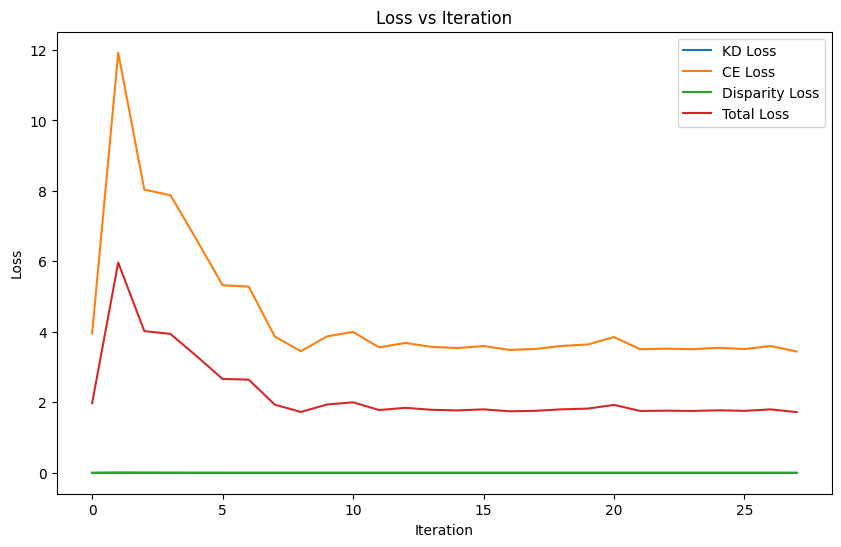

In [20]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Update the total number of epochs to include fine-tuning epochs
total_epochs = num_epochs + fine_tune_epochs

# Lists to store loss values
kd_loss_values = []
ce_loss_values = []
disparity_loss_values = []
total_loss_values = []

# Training loop
for epoch in range(total_epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{total_epochs}')
    # Change learning rate for fine-tuning phase
    if epoch == num_epochs:
        for param_group in optimizer_student.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        for param_group in optimizer_teacher.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        print(f'Starting fine-tuning with learning rate: {fine_tune_learning_rate}')

    student_model.train()
    teacher_model.train()
    for images, labels, annotations in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)

        # Calculate additional metrics including recall
        recall_student = recall_score(labels.cpu().numpy(), torch.argmax(student_outputs, dim=1).cpu().numpy(), average='weighted', zero_division=0)
        recall_teacher = recall_score(labels.cpu().numpy(), torch.argmax(teacher_outputs, dim=1).cpu().numpy(), average='weighted', zero_division=0)

        # Update recall values
        for attr in attributes:
            for concept in concepts:
                # Check if the sample belongs to the specified attribute and concept
                attr_indices = np.where(annotations[:, attr_idx[attr]].cpu().numpy() == 1)[0]  # Get indices where attribute is 1
                concept_indices = np.where(labels.cpu().numpy() == class_to_idx[concept])[0]  # Get indices where concept matches
                common_indices = np.intersect1d(attr_indices, concept_indices)  # Common indices
                if common_indices.size > 0:
                    teacher_recall_values[attr][concept].append(recall_teacher)
                    student_recall_values[attr][concept].append(recall_student)

        # Calculate the Knowledge Distillation loss and Cross Entropy loss
        kd_loss = criterion_student(
            F.log_softmax(student_outputs / temperature, dim=1),  # Apply temperature scaling
            F.softmax(teacher_outputs / temperature, dim=1)  # Apply temperature scaling
        )
        ce_loss = criterion_teacher(student_outputs, labels)
        
        # Append the loss values for plotting
        kd_loss_values.append(kd_loss.item())
        ce_loss_values.append(ce_loss.item())
    
       # Calculate the disparity for each attribute and concept
        disparity_loss_sum = 0  # Initialize a variable to sum the disparity losses
        for attr in attributes:
            for concept in concepts:
                # Calculate the disparity (difference in recall)
                teacher_recall = np.mean(teacher_recall_values[attr][concept])
                student_recall = np.mean(student_recall_values[attr][concept])
                disparity = teacher_recall - student_recall
                disparity_tensor = torch.tensor(disparity, dtype=torch.float32).to(device)  # Convert disparity to a PyTorch tensor
                disparity_loss_sum += disparity_weight * disparity_tensor  # Sum the disparity losses
    
        if torch.isnan(disparity_loss_sum):
            disparity_loss_sum = torch.tensor(0.0, dtype=torch.float32).to(device)
                
        disparity_loss_values.append(disparity_loss_sum.item())
        # Combine the losses
        total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + disparity_loss_sum

        # Append the total loss value for plotting
        total_loss_values.append(total_loss.item())

        # Perform the backward pass
        total_loss.backward()

        # Optimize the models
        optimizer_student.step()
        optimizer_teacher.step()

        # Zero the gradients after updating weights
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        print(f'KD Loss: {kd_loss.item()}')
        print(f'CE Loss: {ce_loss.item()}')
        print(f'Disparity Loss: {disparity_loss_sum.item()}')
        print(f'Total Loss: {total_loss.item()}')


        
        print(f'teacher_recall: {teacher_recall}, student_recall: {student_recall}')

        print(f'Labels: {labels.cpu().numpy()}')
        print(f'Student Predictions: {torch.argmax(student_outputs, dim=1).cpu().numpy()}')
        print(f'Teacher Predictions: {torch.argmax(teacher_outputs, dim=1).cpu().numpy()}')

        print(f'Student Outputs: {student_outputs}')
        print(f'Teacher Outputs: {teacher_outputs}')

# Disable anomaly detection when done
torch.autograd.set_detect_anomaly(False)

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(kd_loss_values, label='KD Loss')
plt.plot(ce_loss_values, label='CE Loss')
plt.plot(disparity_loss_values, label='Disparity Loss')
plt.plot(total_loss_values, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iteration')
plt.show()


# Evaluate

In [21]:
def calculate_disparity(teacher_recall_values, student_recall_values):
    disparity_values = {}
    for attr in attributes:  # Ensure 'attributes' is defined and correctly formatted
        disparity_values[attr] = {}
        for concept in concepts:  # Ensure 'concepts' is defined and correctly formatted
            teacher_values = teacher_recall_values.get(attr, {}).get(concept, [])
            student_values = student_recall_values.get(attr, {}).get(concept, [])
            if teacher_values and student_values:  # Check non-empty lists
                disparity_values[attr][concept] = np.mean(
                    [teacher_val - student_val for teacher_val, student_val in zip(teacher_values, student_values)]
                )
            else:
                print(f"Missing values for attr: {attr}, concept: {concept}")  # Debugging print statement
    return disparity_values

In [22]:
# Validation
student_model.eval()
teacher_model.eval()
val_loss_student = 0.0
val_predictions_student = []
val_targets_student = []

val_loss_teacher = 0.0
val_predictions_teacher = []
val_targets_teacher = []

start_time = time.time()

with torch.no_grad():
    for images, labels, annotations in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        student_outputs = student_model(images)
        teacher_outputs = teacher_model(images)

        # Calculate cross-entropy loss for validation
        student_loss = criterion_teacher(student_outputs, labels)
        teacher_loss = criterion_teacher(teacher_outputs, labels)

        val_loss_student += student_loss.item()
        val_loss_teacher += teacher_loss.item()

        # Store predictions and ground truth labels for metrics
        val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
        val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

        val_targets_student.extend(labels.cpu().numpy())
        val_targets_teacher.extend(labels.cpu().numpy())

end_time = time.time()  # End time measurement
inference_time_student = (end_time - start_time) / len(val_loader)
inference_time_teacher = (end_time - start_time) / len(val_loader)

val_disparity_values = calculate_disparity(teacher_recall_values, student_recall_values)

# Calculate the average disparity
avg_disparity = np.mean(
    [value for attr_dict in val_disparity_values.values()
     for concept_dict in attr_dict.values()
     for value in (concept_dict.values() if isinstance(concept_dict, dict) else [concept_dict])])


# Calculate validation accuracy and recall
val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
val_recall_student = recall_score(val_targets_student, val_predictions_student, average='weighted')
val_recall_teacher = recall_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_precision_student = precision_score(val_targets_student, val_predictions_student, average='weighted')
val_precision_teacher = precision_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_f1_student = f1_score(val_targets_student, val_predictions_student, average='weighted')
val_f1_teacher = f1_score(val_targets_teacher, val_predictions_teacher, average='weighted')

# Get model size (number of parameters)
model_size_student = sum(p.numel() for p in student_model.parameters())
model_size_teacher = sum(p.numel() for p in teacher_model.parameters())

val_metrics_teacher = calculate_metrics(val_targets_teacher, val_predictions_teacher)
val_metrics_student = calculate_metrics(val_targets_student, val_predictions_student)
  
# Gather metrics in dictionaries for easier plotting
teacher_metrics = {
    'Accuracy': val_metrics_teacher[0],
    'Precision': val_metrics_teacher[1],
    'Recall': val_metrics_teacher[2],
    'F1 Score': val_metrics_teacher[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_teacher,
    'Inference Time': inference_time_teacher
}

student_metrics = {
    'Accuracy': val_metrics_student[0],
    'Precision': val_metrics_student[1],
    'Recall': val_metrics_student[2],
    'F1 Score': val_metrics_student[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_student,
    'Inference Time': inference_time_student
}

# Define labels for plotting
size_labels = ['Model Size']
time_labels = ['Inference Time']
other_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Disparity']  # Define labels for other metrics

# Extract values for each type of metric
size_teacher_values = [teacher_metrics['Model Size']]
size_student_values = [student_metrics['Model Size']]

time_teacher_values = [teacher_metrics['Inference Time']]
time_student_values = [student_metrics['Inference Time']]

other_teacher_values = [teacher_metrics[key] for key in other_labels]
other_student_values = [student_metrics[key] for key in other_labels]

# Print validation results for this epoch
print(f'Epoch [{epoch+1}/{num_epochs}]'
      f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
      f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
      f' Teacher Recall: {val_recall_teacher:.4f}'
      f' Student Loss: {val_loss_student / len(val_loader):.4f}'
      f' Student Accuracy: {val_accuracy_student:.4f}'
      f' Student Recall: {val_recall_student:.4f}')

# Print disparity for validation
for attr in attributes:
    for concept in concepts:
        # Handle potential missing values with a default of NaN or another value of your choice
        print(f'Validation Disparity for {attr} and {concept}: {val_disparity_values.get(attr, {}).get(concept, np.nan):.4f}')


Missing values for attr: gender_presentation_masc, concept: patient
Missing values for attr: gender_presentation_masc, concept: nurse
Missing values for attr: gender_presentation_masc, concept: astronaut
Missing values for attr: gender_presentation_masc, concept: climber
Missing values for attr: gender_presentation_masc, concept: disk_jockey
Missing values for attr: gender_presentation_masc, concept: cheerleader
Missing values for attr: gender_presentation_masc, concept: reporter
Missing values for attr: gender_presentation_masc, concept: carpenter
Missing values for attr: gender_presentation_masc, concept: seller
Missing values for attr: gender_presentation_masc, concept: teacher
Missing values for attr: gender_presentation_masc, concept: electrician
Missing values for attr: gender_presentation_masc, concept: bartender
Missing values for attr: gender_presentation_fem, concept: gymnast
Missing values for attr: gender_presentation_fem, concept: lifeguard
Missing values for attr: gender_

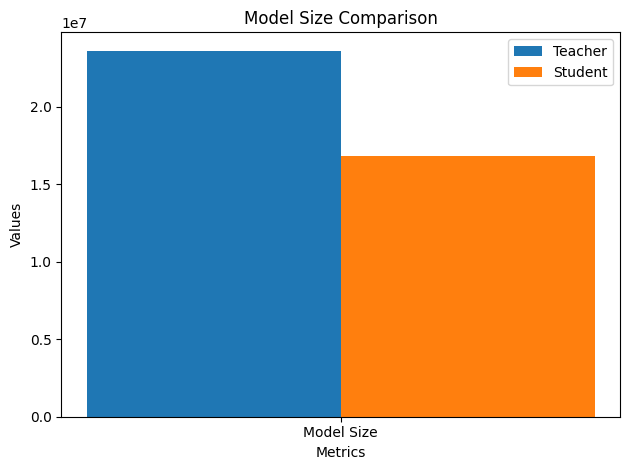

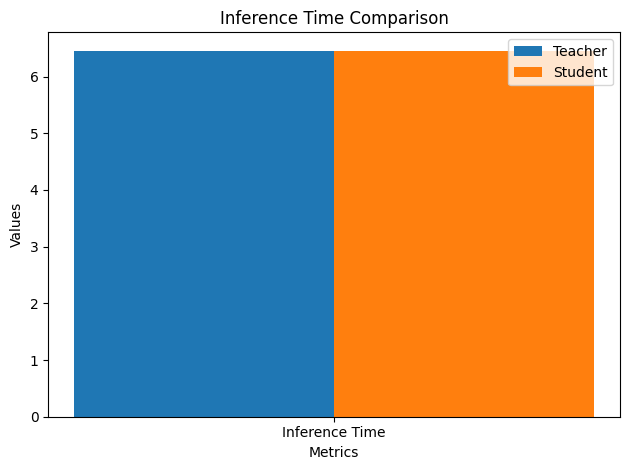

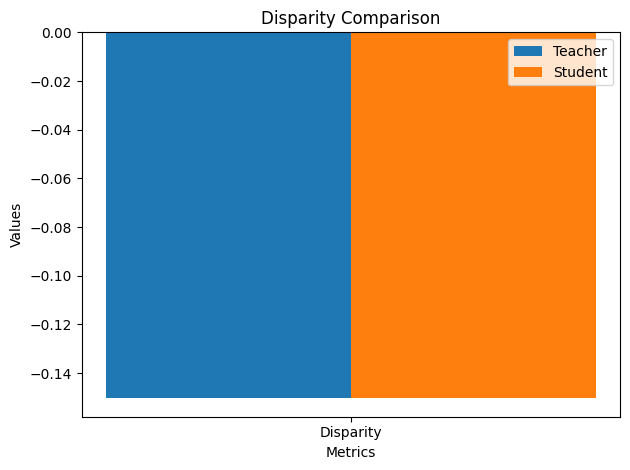

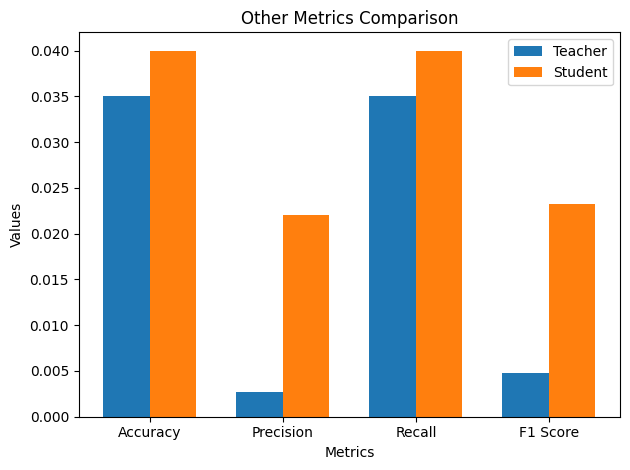

In [23]:
def create_plot(labels, teacher_values, student_values, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Function to create a bar plot specifically for disparity
def plot_disparity(title):
    labels = ['Disparity']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [teacher_metrics['Disparity']], width, label='Teacher')
    rects2 = ax.bar(x + width/2, [student_metrics['Disparity']], width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Create plots
create_plot(size_labels, size_teacher_values, size_student_values, 'Model Size Comparison')
create_plot(time_labels, time_teacher_values, time_student_values, 'Inference Time Comparison')
plot_disparity('Disparity Comparison')
create_plot(other_labels[:-1], other_teacher_values[:-1], other_student_values[:-1], 'Other Metrics Comparison')  

In [24]:
torch.save(student_model.state_dict(), 'student_model2.pth')
torch.save(teacher_model.state_dict(), 'teacher_model2.pth')

In [25]:
accuracy_score(val_targets_student, val_predictions_student)

0.04

In [26]:
accuracy_score(val_targets_teacher, val_predictions_teacher)

0.035

In [27]:
val_loss_student / len(val_loader)

3.830855812345232

In [28]:
val_loss_teacher / len(val_loader)

4.186582429068429